In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedShuffleSplit
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Fluxo Manual (Sem Pipeline)

## Funções de Apoio para tratamento de dados

In [ ]:
# Função para calcular a correlação para colunas numéricas
def calcular_correlacao(X, y):
    correlacoes = X.corrwith(y)
    print("Correlação com y:")
    print(correlacoes.sort_values(ascending=False))
    return correlacoes

# Função para calcular a importância de colunas categóricas usando teste qui-quadrado
def calcular_importancia_categorica(X, y):
    chi_scores, p_values = chi2(X, y)
    importancia_df = pd.DataFrame({
        'Feature': X.columns,
        'Chi2': chi_scores,
        'p-value': p_values
    }).sort_values(by='Chi2', ascending=False)
    print(importancia_df)
    return importancia_df

## Funções de Apoio para vizualização e exploração (Treinamento para teste dos dados)

In [ ]:
def analisar_nulos(X, y):
    # 1. Identifique as linhas com pelo menos um valor nulo em X
    linhas_nulas_X = X.isnull().any(axis=1)
    # 2. Distribuição de y nas linhas com nulos em X
    y_nulos_X = y[linhas_nulas_X]
    # 3. Total de y por categoria
    total_por_categoria = y.value_counts()
    # 4. Total de y_nulos_X por categoria
    nulos_por_categoria = y_nulos_X.value_counts()
    # 5. Proporção de y_nulos_X em relação ao total da categoria
    proporcao_nulos_categoria = (nulos_por_categoria / total_por_categoria).fillna(0)
    # 6. Proporção de y_nulos_X em relação ao total de todos os y
    proporcao_nulos_total = (nulos_por_categoria / len(y)).fillna(0)

    print("\nProporção de y_nulos_X em relação ao total da categoria:")
    print(proporcao_nulos_categoria)
    print("\nProporção de y_nulos_X em relação ao total de todos os y:")
    print(proporcao_nulos_total)

    if not y_nulos_X.empty:
        df_plot = pd.DataFrame({
            'Proporção na Categoria': proporcao_nulos_categoria,
            'Proporção no Total': proporcao_nulos_total
        }).fillna(0)
        df_plot.plot(kind='bar', figsize=(8,4))
        plt.title('Proporção de y (linhas com nulos em X)')
        plt.ylabel('Proporção')
        plt.show()
    else:
        print("Não há linhas com valores nulos em X.")

def plotar_distribuicao(y, title):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Contagem')
    plt.show()

def plotar_matriz_de_dispersao(X, y, columns):
    sns.pairplot(X[columns].join(y), hue=y.name)
    plt.title('Matriz de Dispersão')
    plt.show()

# Função para plotar colunas numéricas mais relevantes com gráfico de dispersão
def plotar_colunas(X, y, colunas_relevantes):
    for col in colunas_relevantes:
        plt.figure(figsize=(8, 4))
        sns.histplot(data=X, x=col, hue=y, kde=True, bins=30, palette="viridis", element="step")
        plt.title(f'Distribuição de {col} em relação a y')
        plt.xlabel(col)
        plt.ylabel('Frequência')
        plt.show()

# Análise inicial do dataset
def analisando_dados_do_dataset(df):
    print('\n[INFO] Informações do DataFrame:')
    print(df.info())
    print('\n[HEAD] Primeiras linhas do DataFrame:')
    print(df.head())
    print('\n[DESCRIBE] Estatísticas descritivas:')
    print(df.describe())
    print('\n[COLUMNS] Nome das colunas:')
    print(df.columns)
    print('\n[NULLS] Quantidade de valores nulos por coluna:')
    print(df.isnull().sum())
    print('\n[DTYPES] Tipos de dados das colunas:')
    print(df.dtypes)
    print('\n[SHAPE] Formato do DataFrame (linhas, colunas):')
    print(df.shape)
    print('\n[MEMORY USAGE] Uso de memória:')
    print(df.memory_usage(deep=True))
    print('\n[ANÁLISE DE NULOS]')
    analisar_nulos(df.drop(columns=['Satisfacao']), df['Satisfacao'])
    print('\n[DISTRIBUIÇÃO DE CLASSES]')
    plotar_distribuicao(df['Satisfacao'], 'Distribuição de Classes')
    

In [ ]:
def update_column_names_and_values(df):
    df = df.rename(columns={
        'Gender': 'Genero',
        'Customer Type': 'Tipo_Cliente',
        'Age': 'Idade',
        'Type of Travel': 'Tipo_Viagem',
        'Class': 'Classe',
        'Flight Distance': 'Distancia_Voo',
        'Inflight wifi service': 'Wifi_Bordo',
        'Departure/Arrival time convenient': 'Horario_Conveniente',
        'Ease of Online booking': 'Facilidade_Reserva_Online',
        'Gate location': 'Localizacao_Portao',
        'Food and drink': 'Comida_Bebida',
        'Online boarding': 'Embarque_Online',
        'Seat comfort': 'Conforto_Assento',
        'Inflight entertainment': 'Entretenimento_Bordo',
        'On-board service': 'Servico_Bordo',
        'Leg room service': 'Espaco_Pernas',
        'Baggage handling': 'Manuseio_Bagagem',
        'Checkin service': 'Servico_Checkin',
        'Inflight service': 'Servico_Bordo_Geral',
        'Cleanliness': 'Limpeza',
        'Departure Delay in Minutes': 'Atraso_Partida_Min',
        'Arrival Delay in Minutes': 'Atraso_Chegada_Min',
        'satisfaction': 'Satisfacao'
    })
    
    df['Satisfacao'] = df['Satisfacao'].map({'neutral or dissatisfied': 'Neutro ou Insatisfeito', 'satisfied': 'Satisfeito'})  # Transformar os valores de 'y'
    df['Genero'] = df['Genero'].map({'Male': 'Homem', 'Female': 'Mulher'})
    df['Tipo_Cliente'] = df['Tipo_Cliente'].map({'Loyal Customer': 'Cliente_Fiel', 'disloyal Customer': 'Cliente_Nao_Fiel'})
    df['Tipo_Viagem'] = df['Tipo_Viagem'].map({'Business travel': 'Viagem_Negocios', 'Personal Travel': 'Viagem_Pessoal'})
    df['Classe'] = df['Classe'].map({'Business': 'Executivo', 'Eco Plus': 'Economica_Plus', 'Eco': 'Economica'})
    return df

   Genero      Tipo_Cliente  Idade      Tipo_Viagem     Classe  Distancia_Voo  \
0   Homem  Cliente_Nao_Fiel     48  Viagem_Negocios  Executivo            821   
1  Mulher      Cliente_Fiel     35  Viagem_Negocios  Executivo            821   
2   Homem      Cliente_Fiel     41  Viagem_Negocios  Executivo            853   
3   Homem      Cliente_Fiel     50  Viagem_Negocios  Executivo           1905   
4  Mulher      Cliente_Fiel     49  Viagem_Negocios  Executivo           3470   

   Wifi_Bordo  Horario_Conveniente  Facilidade_Reserva_Online  \
0           3                    3                          3   
1           2                    2                          2   
2           4                    4                          4   
3           2                    2                          2   
4           3                    3                          3   

   Localizacao_Portao  ...  Entretenimento_Bordo  Servico_Bordo  \
0                   3  ...                     5       

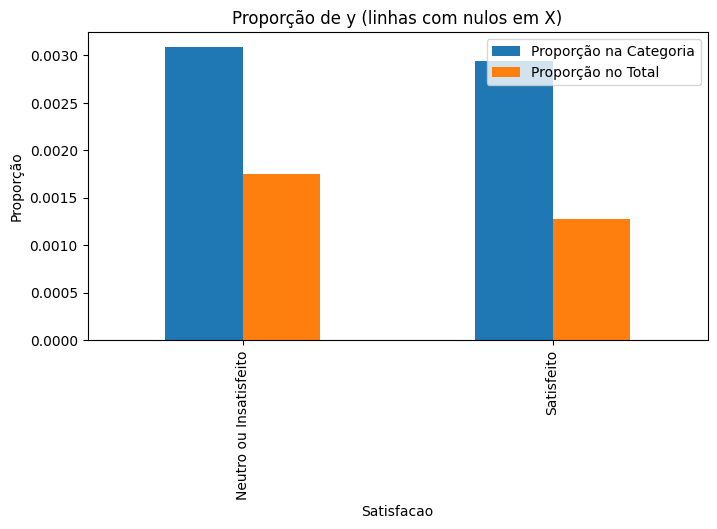


[DISTRIBUIÇÃO DE CLASSES]


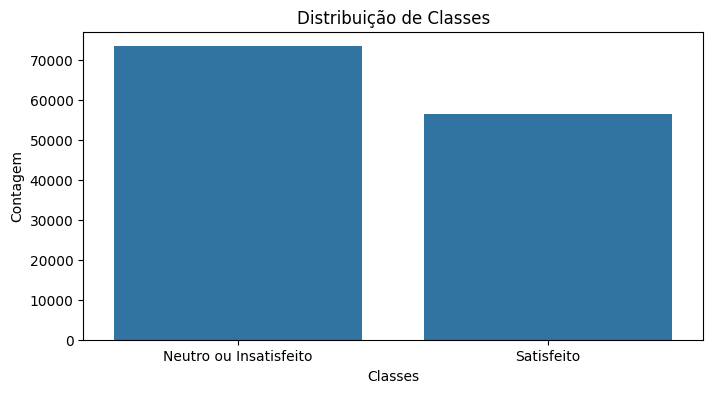

In [ ]:
df_polars = pl.read_csv('fly_satisfaction.csv')

# Converter para PyArrow Table
arrow_table = df_polars.to_arrow()

# Converter para Pandas DataFrame
df = pd.DataFrame(arrow_table.to_pydict())
df = update_column_names_and_values(df)

# Verificar o DataFrame
print(df.head())

analisando_dados_do_dataset(df)

In [ ]:
# Separar X e y
X = df.drop(columns=['Satisfacao'])
y = df['Satisfacao']

# Definir se deseja aplicar transformação logarítmica e escalonamento
willUseScaler = True
willUseLogTransform = True

# Separar colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(include=[np.number]).columns
colunas_categoricas = X.select_dtypes(include=['object']).columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

In [ ]:
# Verificar se há colunas categóricas
if colunas_categoricas.empty:
    print("Não há colunas categóricas para transformar.")
else:
    # Criar o encoder
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Ajustar o encoder no conjunto de treino e transformar
    X_train_categorico_encoded = encoder.fit_transform(X_train[colunas_categoricas])
    X_test_categorico_encoded = encoder.transform(X_test[colunas_categoricas])

    # Converter os resultados do OneHotEncoder para DataFrames
    X_train_categorico_encoded_df = pd.DataFrame(
        X_train_categorico_encoded,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=X_train.index
    )
    X_test_categorico_encoded_df = pd.DataFrame(
        X_test_categorico_encoded,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=X_test.index
    )

    # Concatenar as colunas numéricas e categóricas transformadas
    X_train = pd.concat([X_train[colunas_numericas], X_train_categorico_encoded_df], axis=1)
    X_test = pd.concat([X_test[colunas_numericas], X_test_categorico_encoded_df], axis=1)

    print("Colunas categóricas codificadas no conjunto de treino:")
    print(X_train_categorico_encoded_df.head())
    print("Colunas categóricas codificadas no conjunto de teste:")
    print(X_test_categorico_encoded_df.head())
    
# Criar o LabelEncoder
le = LabelEncoder()

# Ajustar o encoder no conjunto de treino e transformar
y_train_encoded = pd.Series(le.fit_transform(y_train), name="target")

# Transformar o conjunto de teste com o mesmo encoder
y_test_encoded = pd.Series(le.transform(y_test), name="target")

# Verificar os resultados
print("y_train codificado:")
print(y_train_encoded.head())
print("y_test codificado:")
print(y_test_encoded.head())

Colunas categóricas codificadas no conjunto de treino:
        Genero_Mulher  Tipo_Cliente_Cliente_Nao_Fiel  \
28817             1.0                            0.0   
39717             0.0                            0.0   
120220            1.0                            0.0   
47602             0.0                            0.0   
57721             1.0                            0.0   

        Tipo_Viagem_Viagem_Pessoal  Classe_Economica_Plus  Classe_Executivo  
28817                          0.0                    0.0               1.0  
39717                          0.0                    0.0               1.0  
120220                         0.0                    0.0               1.0  
47602                          0.0                    0.0               1.0  
57721                          0.0                    0.0               1.0  
Colunas categóricas codificadas no conjunto de teste:
        Genero_Mulher  Tipo_Cliente_Cliente_Nao_Fiel  \
93370             0.0         

In [ ]:
# Verificar valores nulos antes e depois do SimpleImputer
print("Valores nulos antes do imputação:")
print(X_train[colunas_numericas].isnull().sum())
print(X_test[colunas_numericas].isnull().sum())

# Aplicar o SimpleImputer
impu = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[colunas_numericas] = impu.fit_transform(X_train[colunas_numericas])
X_test[colunas_numericas] = impu.transform(X_test[colunas_numericas])

print("Valores nulos após a imputação:")
print(pd.DataFrame(X_train, columns=colunas_numericas).isnull().sum())
print(pd.DataFrame(X_test, columns=colunas_numericas).isnull().sum())

Valores nulos antes do imputação:
Idade                          0
Distancia_Voo                  0
Wifi_Bordo                     0
Horario_Conveniente            0
Facilidade_Reserva_Online      0
Localizacao_Portao             0
Comida_Bebida                  0
Embarque_Online                0
Conforto_Assento               0
Entretenimento_Bordo           0
Servico_Bordo                  0
Espaco_Pernas                  0
Manuseio_Bagagem               0
Servico_Checkin                0
Servico_Bordo_Geral            0
Limpeza                        0
Atraso_Partida_Min             0
Atraso_Chegada_Min           271
dtype: int64
Idade                          0
Distancia_Voo                  0
Wifi_Bordo                     0
Horario_Conveniente            0
Facilidade_Reserva_Online      0
Localizacao_Portao             0
Comida_Bebida                  0
Embarque_Online                0
Conforto_Assento               0
Entretenimento_Bordo           0
Servico_Bordo                

In [ ]:
if willUseLogTransform:
    # Aplicar log-transform nas colunas numéricas
    X_train[colunas_numericas] = X_train[colunas_numericas].apply(lambda x: np.log(x + 1e-8))
    X_test[colunas_numericas] = X_test[colunas_numericas].apply(lambda x: np.log(x + 1e-8))

    # Verificar se a transformação log foi aplicada corretamente
    print("Colunas numéricas após log-transform:")
    print(X_train[colunas_numericas].head())
    print(X_test[colunas_numericas].head())

Colunas numéricas após log-transform:
           Idade  Distancia_Voo    Wifi_Bordo  Horario_Conveniente  \
28817   3.828641       7.802618  1.386294e+00             1.386294   
39717   3.401197       5.768321  6.931472e-01             0.693147   
120220  3.970292       7.945910  1.000000e-08             1.098612   
47602   3.891820       7.264030  1.386294e+00             1.386294   
57721   3.367296       7.469654  1.098612e+00             1.098612   

        Facilidade_Reserva_Online  Localizacao_Portao  Comida_Bebida  \
28817                    0.693147            1.386294       0.693147   
39717                    0.693147            0.693147       1.098612   
120220                   1.098612            1.098612       1.098612   
47602                    1.386294            1.386294       1.609438   
57721                    1.098612            1.098612       1.386294   

        Embarque_Online  Conforto_Assento  Entretenimento_Bordo  \
28817      1.000000e-08      1.098612e+00

In [ ]:
# Transformar colunas numéricas com escalonamento
if willUseScaler:
    print("Colunas numéricas após log-transform:")
    print(X_train[colunas_numericas].head())
    scaler = StandardScaler()
    
    # Escalonar colunas numéricas
    X_train[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])
    X_test[colunas_numericas] = scaler.transform(X_test[colunas_numericas])
    
    # Verificar se o escalonamento foi aplicado corretamente
    print("Colunas numéricas escalonadas:")
    print(X_train[colunas_numericas].head())
    print(X_test[colunas_numericas].head())

Colunas numéricas após log-transform:
           Idade  Distancia_Voo    Wifi_Bordo  Horario_Conveniente  \
28817   3.828641       7.802618  1.386294e+00             1.386294   
39717   3.401197       5.768321  6.931472e-01             0.693147   
120220  3.970292       7.945910  1.000000e-08             1.098612   
47602   3.891820       7.264030  1.386294e+00             1.386294   
57721   3.367296       7.469654  1.098612e+00             1.098612   

        Facilidade_Reserva_Online  Localizacao_Portao  Comida_Bebida  \
28817                    0.693147            1.386294       0.693147   
39717                    0.693147            0.693147       1.098612   
120220                   1.098612            1.098612       1.098612   
47602                    1.386294            1.386294       1.609438   
57721                    1.098612            1.098612       1.386294   

        Embarque_Online  Conforto_Assento  Entretenimento_Bordo  \
28817      1.000000e-08      1.098612e+00

In [ ]:
# Verificar o resultado final de X
print("X final após transformações:")
print(X_train.head())

# Verificar o resultado final de y
print("y final após transformações:")
print(y_train[:5])

X final após transformações:
           Idade  Distancia_Voo  Wifi_Bordo  Horario_Conveniente  \
28817   0.532361       1.197492    0.314991             0.310956   
39717  -0.387967      -1.016772    0.108086             0.151983   
120220  0.837348       1.353460   -0.098818             0.244977   
47602   0.668391       0.611257    0.314991             0.310956   
57721  -0.460961       0.835072    0.229118             0.244977   

        Facilidade_Reserva_Online  Localizacao_Portao  Comida_Bebida  \
28817                    0.152085            0.790579      -0.427095   
39717                    0.152085           -0.535618       0.079380   
120220                   0.253396            0.240158       0.079380   
47602                    0.325277            0.790579       0.717464   
57721                    0.253396            0.240158       0.438730   

        Embarque_Online  Conforto_Assento  Entretenimento_Bordo  ...  \
28817         -0.210942         -0.064795              0.

Correlação com y:
Atraso_Partida_Min               0.007158
Idade                            0.005713
Espaco_Pernas                    0.005456
Distancia_Voo                    0.005089
Horario_Conveniente              0.005037
Tipo_Viagem_Viagem_Pessoal       0.003071
Classe_Executivo                 0.001832
Classe_Economica_Plus            0.001795
Atraso_Chegada_Min               0.001267
Embarque_Online                 -0.000552
Facilidade_Reserva_Online       -0.001272
Conforto_Assento                -0.002190
Genero_Mulher                   -0.002417
Servico_Bordo_Geral             -0.003746
Limpeza                         -0.004162
Wifi_Bordo                      -0.004247
Manuseio_Bagagem                -0.004397
Comida_Bebida                   -0.004796
Servico_Bordo                   -0.004905
Localizacao_Portao              -0.005020
Entretenimento_Bordo            -0.007319
Tipo_Cliente_Cliente_Nao_Fiel   -0.007642
Servico_Checkin                 -0.007669
dtype: float64


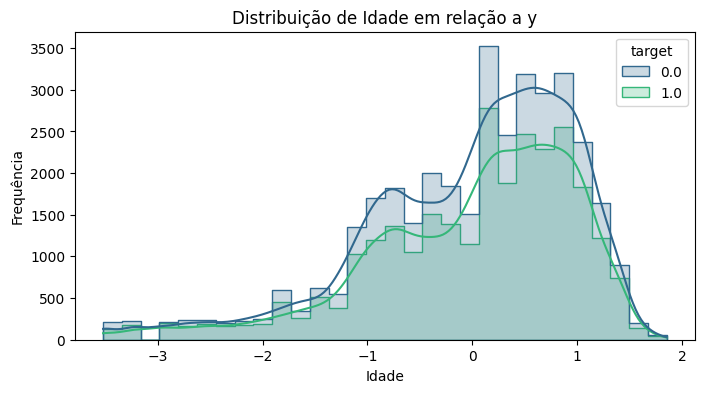

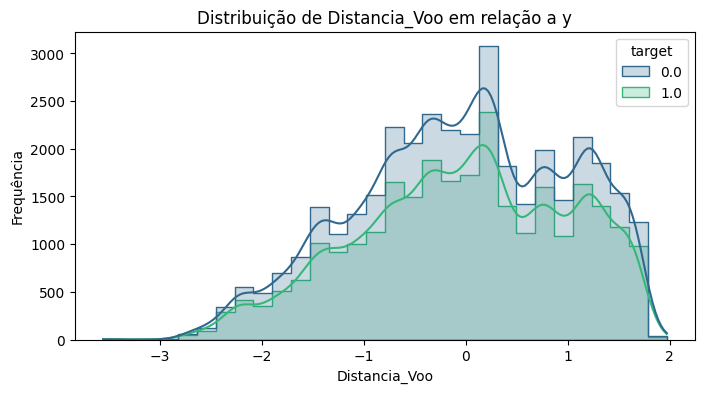

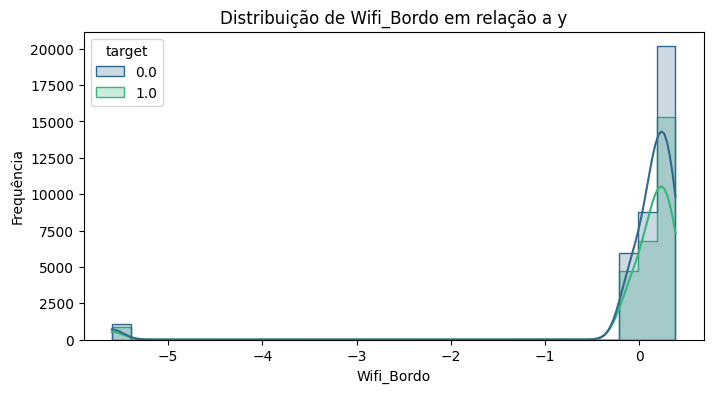

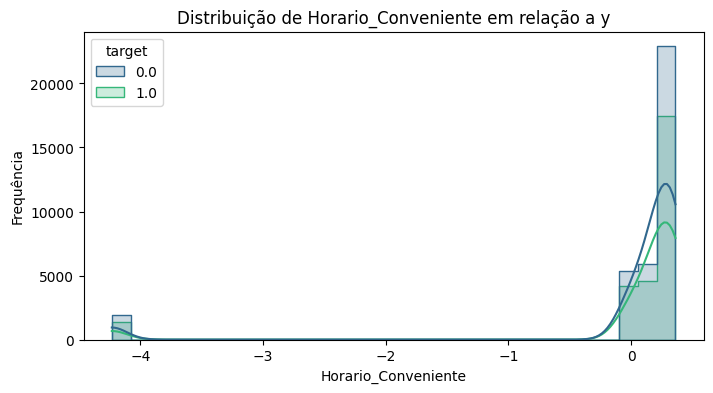

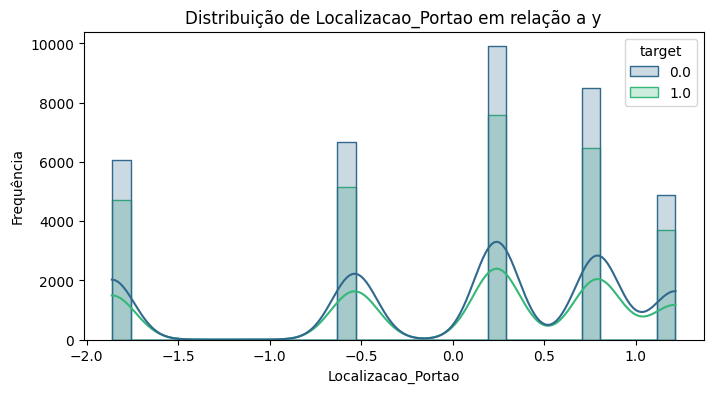

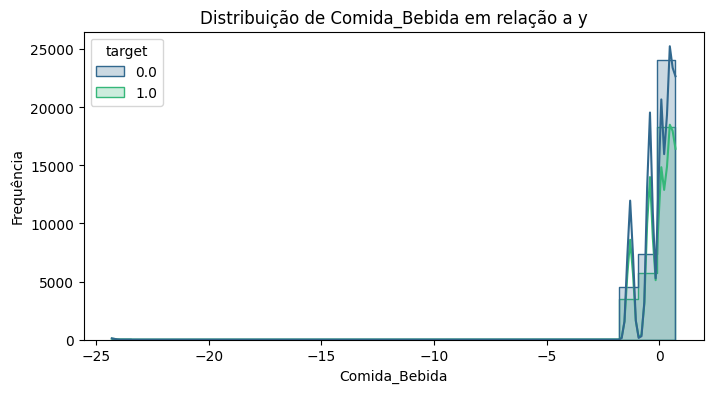

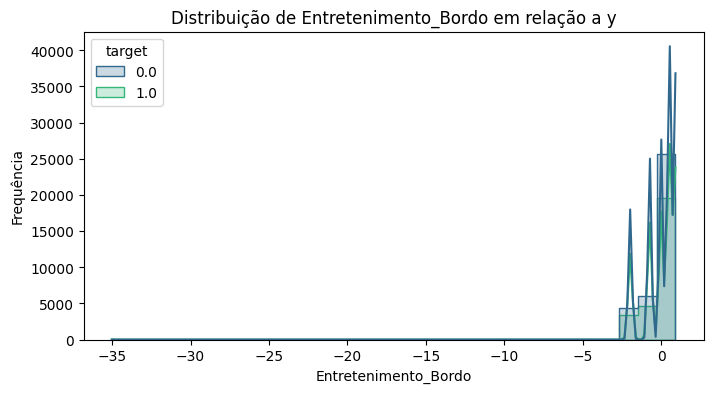

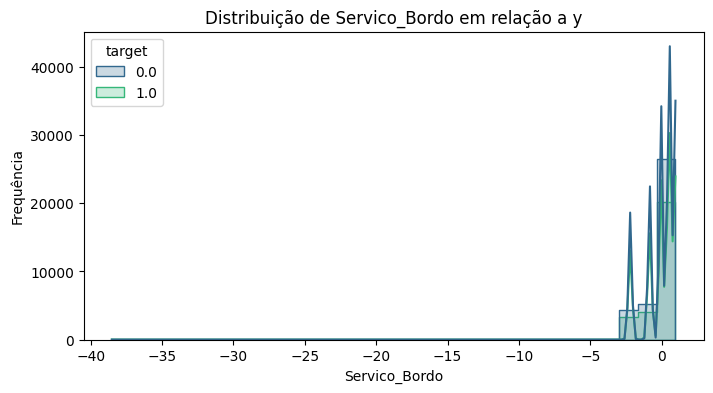

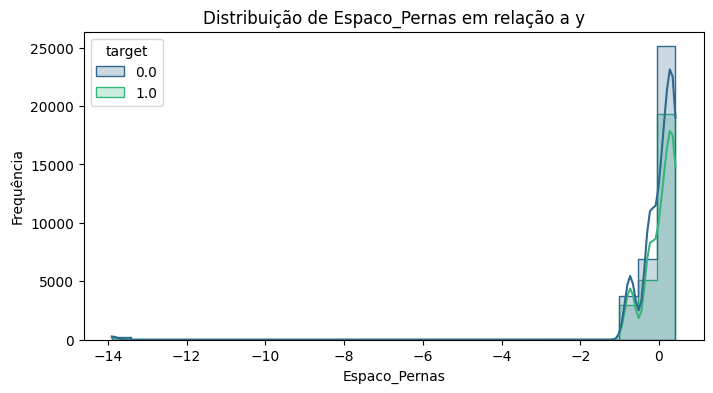

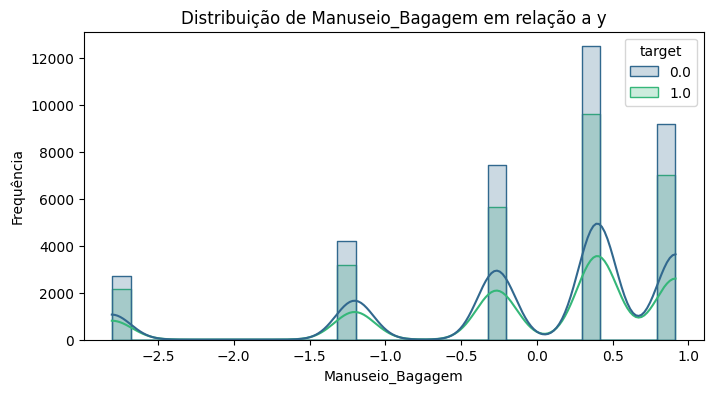

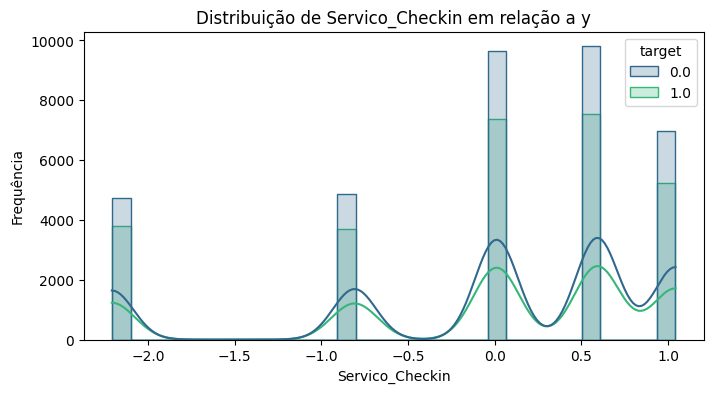

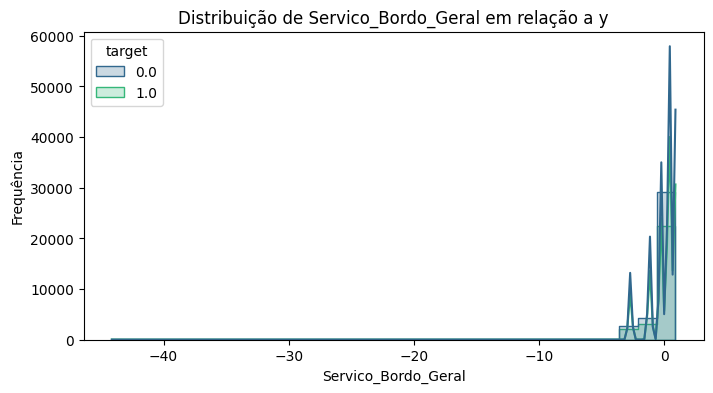

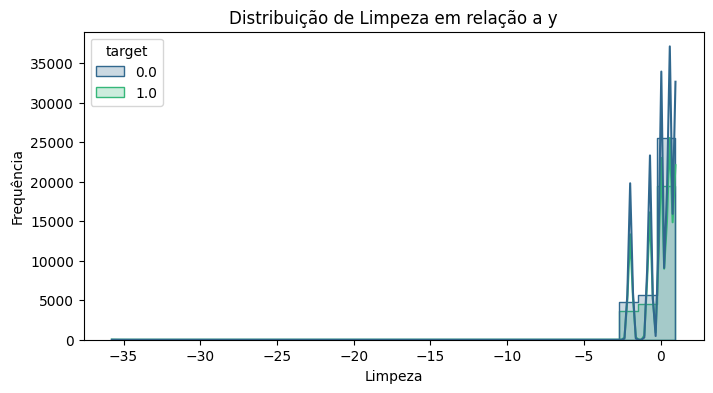

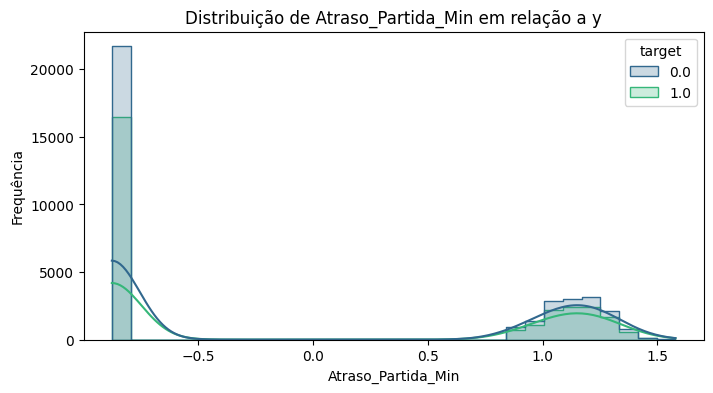

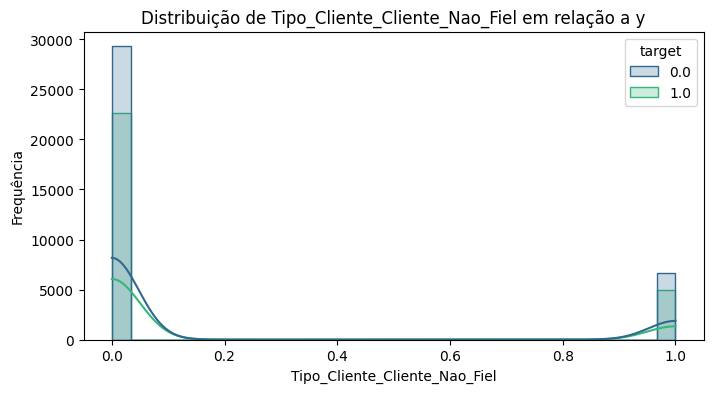

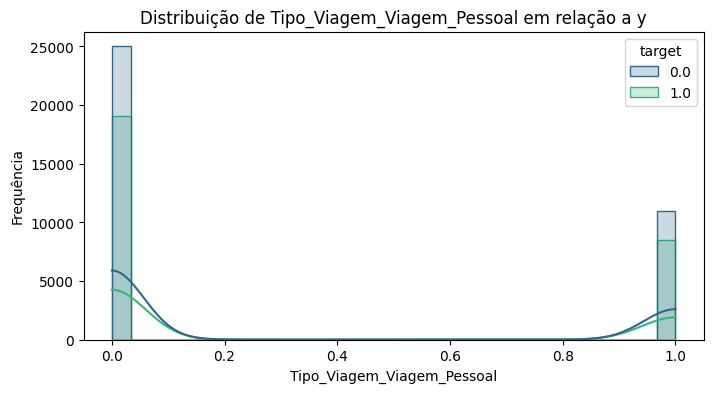

In [ ]:
# Calcular correlação para colunas numéricas no conjunto de treino
correlacoes = calcular_correlacao(X_train, y_train_encoded)

# Selecionar colunas mais relevantes
colunas_numericas_relevantes = correlacoes[correlacoes.abs() > 0.0025].index  # Ajuste o limiar conforme necessário

# Plotar colunas mais relevantes
plotar_colunas(X_train, y_train_encoded, colunas_numericas_relevantes)

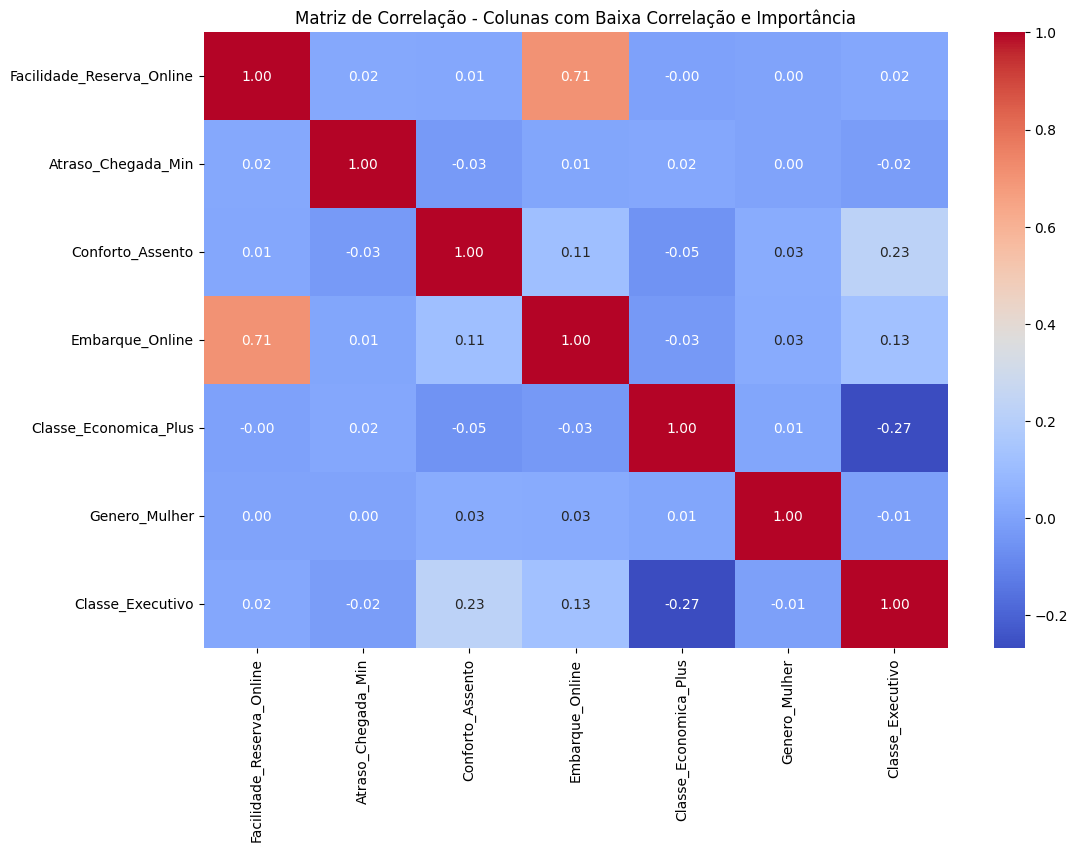

In [ ]:
# Definir limiares para baixa correlação e baixa importância
limiar_correlacao = 0.0025
limiar_multicolinearidade = 0.8

# Identificar colunas com baixa correlação
colunas_baixa_correlacao = correlacoes[correlacoes.abs() < limiar_correlacao].index

# Combinar as colunas com baixa correlação e baixa importância categórica
colunas_para_analisar = list(set(colunas_baixa_correlacao))

# Filtrar o DataFrame com as colunas selecionadas
X_para_analisar = X_train[colunas_para_analisar]

# Criar a matriz de correlação
matriz_correlacao = X_para_analisar.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size":10})
plt.title('Matriz de Correlação - Colunas com Baixa Correlação e Importância')
plt.show()

In [ ]:
# Identificar multicolinearidade
matriz_correlacao = X_train.corr()

# Encontrar pares de features altamente correlacionadas
features_multicolineares = set('')
for col in matriz_correlacao.columns:
    for row in matriz_correlacao.index:
        if col != row and abs(matriz_correlacao.loc[row, col]) > limiar_multicolinearidade:
            features_multicolineares.add(col)

# Combinar todas as features candidatas à remoção
features_para_remover = set(colunas_baixa_correlacao).union(features_multicolineares)

print(f"Features com baixa correlação com y: {colunas_baixa_correlacao}")
print(f"Features multicolineares: {features_multicolineares}")
print(f"Features candidatas à remoção: {features_para_remover}")

Features com baixa correlação com y: Index(['Facilidade_Reserva_Online', 'Embarque_Online', 'Conforto_Assento',
       'Atraso_Chegada_Min', 'Genero_Mulher', 'Classe_Economica_Plus',
       'Classe_Executivo'],
      dtype='object')
Features multicolineares: set()
Features candidatas à remoção: {'Classe_Executivo', 'Facilidade_Reserva_Online', 'Atraso_Chegada_Min', 'Conforto_Assento', 'Embarque_Online', 'Classe_Economica_Plus', 'Genero_Mulher'}


In [ ]:
# Dropando a feature Com alta Correlação Entre outra feature
features_escolhidas = ['Facilidade_Reserva_Online','Embarque_Online']

## Após Analise Feita para exploração dos dados e diminuição de dimensionalidade
## Agora o treinamento real do modelo será feito

   Genero      Tipo_Cliente  Idade      Tipo_Viagem     Classe  Distancia_Voo  \
0   Homem  Cliente_Nao_Fiel     48  Viagem_Negocios  Executivo            821   
1  Mulher      Cliente_Fiel     35  Viagem_Negocios  Executivo            821   
2   Homem      Cliente_Fiel     41  Viagem_Negocios  Executivo            853   
3   Homem      Cliente_Fiel     50  Viagem_Negocios  Executivo           1905   
4  Mulher      Cliente_Fiel     49  Viagem_Negocios  Executivo           3470   

   Wifi_Bordo  Horario_Conveniente  Localizacao_Portao  Comida_Bebida  ...  \
0           3                    3                   3              5  ...   
1           2                    2                   2              3  ...   
2           4                    4                   4              5  ...   
3           2                    2                   2              4  ...   
4           3                    3                   3              4  ...   

   Entretenimento_Bordo  Servico_Bordo  Espa

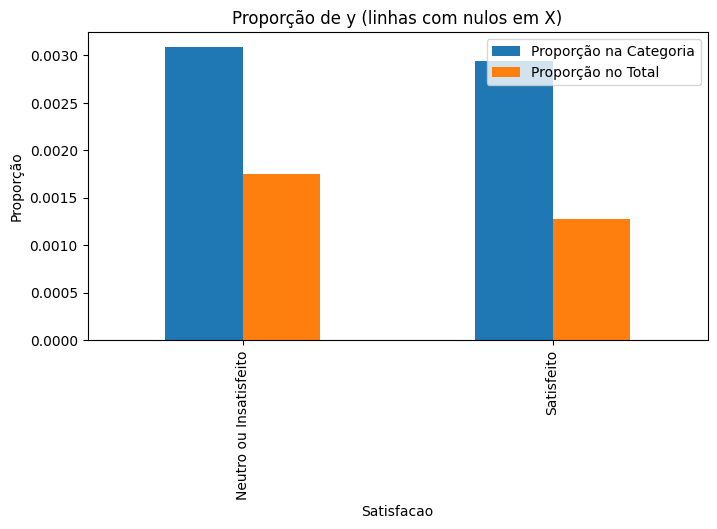


[DISTRIBUIÇÃO DE CLASSES]


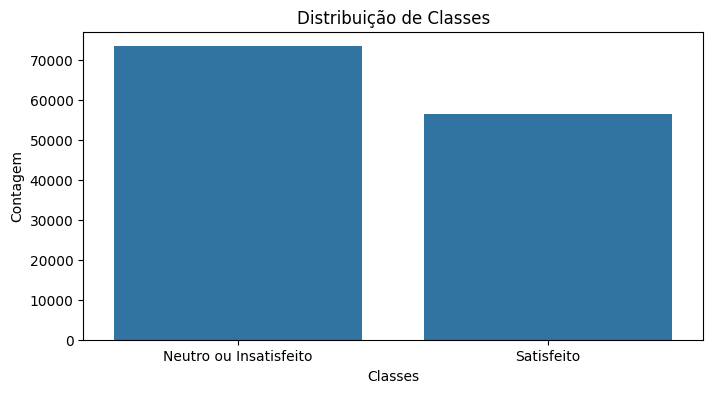

In [ ]:
df_polars = pl.read_csv('fly_satisfaction.csv')

# Converter para PyArrow Table
arrow_table = df_polars.to_arrow()

# Converter para Pandas DataFrame
df = pd.DataFrame(arrow_table.to_pydict())
df = update_column_names_and_values(df)

df.drop(columns=features_escolhidas, inplace=True)
# Verificar o DataFrame
print(df.head())

analisando_dados_do_dataset(df)

In [ ]:
X = df.drop(columns=['Satisfacao'])
y = df['Satisfacao']

# Definir se deseja aplicar transformação logarítmica e escalonamento
willUseScaler = True
willUseLogTransform = True

# Separar colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(include=[np.number]).columns
colunas_categoricas = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

In [ ]:
# Verificar se há colunas categóricas
if colunas_categoricas.empty:
    print("Não há colunas categóricas para transformar.")
else:
    # Criar o encoder
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Ajustar o encoder no conjunto de treino e transformar
    X_train_categorico_encoded = encoder.fit_transform(X_train[colunas_categoricas])
    X_test_categorico_encoded = encoder.transform(X_test[colunas_categoricas])

    # Converter os resultados do OneHotEncoder para DataFrames
    X_train_categorico_encoded_df = pd.DataFrame(
        X_train_categorico_encoded,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=X_train.index
    )
    X_test_categorico_encoded_df = pd.DataFrame(
        X_test_categorico_encoded,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=X_test.index
    )

    # Concatenar as colunas numéricas e categóricas transformadas
    X_train = pd.concat([X_train[colunas_numericas], X_train_categorico_encoded_df], axis=1)
    X_test = pd.concat([X_test[colunas_numericas], X_test_categorico_encoded_df], axis=1)

    print("Colunas categóricas codificadas no conjunto de treino:")
    print(X_train_categorico_encoded_df.head())
    print("Colunas categóricas codificadas no conjunto de teste:")
    print(X_test_categorico_encoded_df.head())
    
# Criar o LabelEncoder
le = LabelEncoder()

# Ajustar o encoder no conjunto de treino e transformar
y_train_encoded = pd.Series(le.fit_transform(y_train), name="target")

# Transformar o conjunto de teste com o mesmo encoder
y_test_encoded = pd.Series(le.transform(y_test), name="target")

# Verificar os resultados
print("y_train codificado:")
print(y_train_encoded.head())
print("y_test codificado:")
print(y_test_encoded.head())

Colunas categóricas codificadas no conjunto de treino:
        Genero_Mulher  Tipo_Cliente_Cliente_Nao_Fiel  \
28817             1.0                            0.0   
39717             0.0                            0.0   
120220            1.0                            0.0   
47602             0.0                            0.0   
57721             1.0                            0.0   

        Tipo_Viagem_Viagem_Pessoal  Classe_Economica_Plus  Classe_Executivo  
28817                          0.0                    0.0               1.0  
39717                          0.0                    0.0               1.0  
120220                         0.0                    0.0               1.0  
47602                          0.0                    0.0               1.0  
57721                          0.0                    0.0               1.0  
Colunas categóricas codificadas no conjunto de teste:
        Genero_Mulher  Tipo_Cliente_Cliente_Nao_Fiel  \
93370             0.0         

In [ ]:
# Verificar valores nulos antes e depois do SimpleImputer
print("Valores nulos antes do imputação:")
print(X_train[colunas_numericas].isnull().sum())
print(X_test[colunas_numericas].isnull().sum())

# Aplicar o SimpleImputer
impu = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[colunas_numericas] = impu.fit_transform(X_train[colunas_numericas])
X_test[colunas_numericas] = impu.transform(X_test[colunas_numericas])

print("Valores nulos após a imputação:")
print(pd.DataFrame(X_train, columns=colunas_numericas).isnull().sum())
print(pd.DataFrame(X_test, columns=colunas_numericas).isnull().sum())

Valores nulos antes do imputação:
Idade                     0
Distancia_Voo             0
Wifi_Bordo                0
Horario_Conveniente       0
Localizacao_Portao        0
Comida_Bebida             0
Conforto_Assento          0
Entretenimento_Bordo      0
Servico_Bordo             0
Espaco_Pernas             0
Manuseio_Bagagem          0
Servico_Checkin           0
Servico_Bordo_Geral       0
Limpeza                   0
Atraso_Partida_Min        0
Atraso_Chegada_Min      271
dtype: int64
Idade                     0
Distancia_Voo             0
Wifi_Bordo                0
Horario_Conveniente       0
Localizacao_Portao        0
Comida_Bebida             0
Conforto_Assento          0
Entretenimento_Bordo      0
Servico_Bordo             0
Espaco_Pernas             0
Manuseio_Bagagem          0
Servico_Checkin           0
Servico_Bordo_Geral       0
Limpeza                   0
Atraso_Partida_Min        0
Atraso_Chegada_Min      122
dtype: int64
Valores nulos após a imputação:
Idade       

In [ ]:
if willUseLogTransform:
    # Aplicar log-transform nas colunas numéricas
    X_train = X_train.apply(lambda x: np.log(x + 1e-8))
    X_test = X_test.apply(lambda x: np.log(x + 1e-8))

    # Verificar se a transformação log foi aplicada corretamente
    print("Colunas após log-transform:")
    print(X_train.head())
    print(X_test.head())

Colunas após log-transform:
           Idade  Distancia_Voo    Wifi_Bordo  Horario_Conveniente  \
28817   3.828641       7.802618  1.386294e+00             1.386294   
39717   3.401197       5.768321  6.931472e-01             0.693147   
120220  3.970292       7.945910  1.000000e-08             1.098612   
47602   3.891820       7.264030  1.386294e+00             1.386294   
57721   3.367296       7.469654  1.098612e+00             1.098612   

        Localizacao_Portao  Comida_Bebida  Conforto_Assento  \
28817             1.386294       0.693147      1.098612e+00   
39717             0.693147       1.098612      1.098612e+00   
120220            1.098612       1.098612      1.098612e+00   
47602             1.386294       1.609438      1.000000e-08   
57721             1.098612       1.386294      1.386294e+00   

        Entretenimento_Bordo  Servico_Bordo  Espaco_Pernas  ...  \
28817           1.609438e+00   1.609438e+00       1.609438  ...   
39717           1.098612e+00   6.93147

In [ ]:
# Transformar colunas numéricas com escalonamento
if willUseScaler:
    print("Colunas numéricas após log-transform:")
    print(X_train[colunas_numericas].head())
    scaler = StandardScaler()
    
    # Escalonar colunas numéricas
    X_train[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])
    X_test[colunas_numericas] = scaler.transform(X_test[colunas_numericas])
    
    # Verificar se o escalonamento foi aplicado corretamente
    print("Colunas numéricas escalonadas:")
    print(X_train[colunas_numericas].head())
    print(X_test[colunas_numericas].head())

Colunas numéricas após log-transform:
           Idade  Distancia_Voo    Wifi_Bordo  Horario_Conveniente  \
28817   3.828641       7.802618  1.386294e+00             1.386294   
39717   3.401197       5.768321  6.931472e-01             0.693147   
120220  3.970292       7.945910  1.000000e-08             1.098612   
47602   3.891820       7.264030  1.386294e+00             1.386294   
57721   3.367296       7.469654  1.098612e+00             1.098612   

        Localizacao_Portao  Comida_Bebida  Conforto_Assento  \
28817             1.386294       0.693147      1.098612e+00   
39717             0.693147       1.098612      1.098612e+00   
120220            1.098612       1.098612      1.098612e+00   
47602             1.386294       1.609438      1.000000e-08   
57721             1.098612       1.386294      1.386294e+00   

        Entretenimento_Bordo  Servico_Bordo  Espaco_Pernas  Manuseio_Bagagem  \
28817           1.609438e+00   1.609438e+00       1.609438      1.609438e+00   
39

In [ ]:
# Verificar o resultado final de X
print("X final após transformações:")
print(X_train.head())

# Verificar o resultado final de y
print("y final após transformações:")
print(y_train[:5])

X final após transformações:
           Idade  Distancia_Voo  Wifi_Bordo  Horario_Conveniente  \
28817   0.532361       1.197492    0.314991             0.310956   
39717  -0.387967      -1.016772    0.108086             0.151983   
120220  0.837348       1.353460   -0.098818             0.244977   
47602   0.668391       0.611257    0.314991             0.310956   
57721  -0.460961       0.835072    0.229118             0.244977   

        Localizacao_Portao  Comida_Bebida  Conforto_Assento  \
28817             0.790579      -0.427095         -0.064795   
39717            -0.535618       0.079380         -0.064795   
120220            0.240158       0.079380         -0.064795   
47602             0.790579       0.717464         -2.240322   
57721             0.240158       0.438730          0.504888   

        Entretenimento_Bordo  Servico_Bordo  Espaco_Pernas  ...  \
28817               0.913244       0.970396       0.418597  ...   
39717              -0.003182      -0.835969      

In [ ]:
# Avaliando um modelo Simples

bscv = BayesSearchCV(
    estimator= LogisticRegression(),
    search_spaces={
        'C': Real(1e-3, 1.0, prior='log-uniform'),
        'solver': Categorical(['liblinear', 'lbfgs']),
        'max_iter': Integer(100, 500),
    },
    n_iter=1,
    cv=3,
    scoring='f1',
    random_state=42
)
bscv.fit(X_train, y_train_encoded)
print("Melhores parâmetros encontrados:")
print(bscv.best_params_)
print("Melhor pontuação:")
print(bscv.best_score_)
print("Melhor estimador:")
print(bscv.best_estimator_)
print("Melhor pontuação de validação cruzada:")
print(bscv.cv_results_['mean_test_score'][bscv.best_index_])
print("Melhores parâmetros encontrados:")
print(bscv.best_params_)

Melhores parâmetros encontrados:
OrderedDict({'C': 0.016994636371262764, 'max_iter': 391, 'solver': 'lbfgs'})
Melhor pontuação:
0.8299954046336535
Melhor estimador:
LogisticRegression(C=0.016994636371262764, max_iter=391)
Melhor pontuação de validação cruzada:
0.8299954046336535
Melhores parâmetros encontrados:
OrderedDict({'C': 0.016994636371262764, 'max_iter': 391, 'solver': 'lbfgs'})


# Modelo Automatizado por Pipelines

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline


numeric_features_pt = [
    'Idade',
    'Distancia_Voo',
    'Wifi_Bordo',
    'Horario_Conveniente',
    'Localizacao_Portao',
    'Comida_Bebida',
    'Conforto_Assento',
    'Entretenimento_Bordo',
    'Servico_Bordo',
    'Espaco_Pernas',
    'Manuseio_Bagagem',
    'Servico_Checkin',
    'Servico_Bordo_Geral',
    'Limpeza',
    'Atraso_Partida_Min',
    'Atraso_Chegada_Min'
]

categorical_features_pt = [
    'Genero',
    'Tipo_Cliente',
    'Tipo_Viagem',
    'Classe'
]

features_numericas_atualizadas = []

def drop_columns(df):
    return df.drop(['Facilidade_Reserva_Online', 'Embarque_Online'], axis=1)

def log_transform(x):
    return np.log(x + 1e-8)

# 2. Transformadores reutilizáveis
drop_columns_transformer = FunctionTransformer(drop_columns, validate=False)
numeric_imputer   = SimpleImputer(strategy='mean')
numeric_log       = FunctionTransformer(log_transform, validate=False)
numeric_scaler    = StandardScaler()

categorical_ohe   = OneHotEncoder(handle_unknown='ignore')

# 3. ColumnTransformer para diferentes combinações
# Com log e scaling
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', numeric_imputer),
        ('log', numeric_log),
        ('scaler', numeric_scaler)
    ]), numeric_features_pt),
    ('cat', categorical_ohe, categorical_features_pt)
], remainder='passthrough')

# Sem log
preprocessor_no_log = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', numeric_imputer),
        ('scaler', numeric_scaler)
    ]), numeric_features_pt),
    ('cat', categorical_ohe, categorical_features_pt)
], remainder='passthrough')

# Sem scaling
preprocessor_no_scale = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', numeric_imputer),
        ('log', numeric_log)
    ]), numeric_features_pt),
    ('cat', categorical_ohe, categorical_features_pt)
], remainder='passthrough')

# Sem log e sem scaling
preprocessor_simple = ColumnTransformer([
    ('num', numeric_imputer, numeric_features_pt),
    ('cat', categorical_ohe, categorical_features_pt)
], remainder='passthrough')

# 4. Pipelines finais com SMOTE
pipeline = ImbPipeline([
    ('drop_cols', drop_columns_transformer),
    ('preproc', preprocessor),
    ('smote',   SMOTE())
])
pipeline_no_scale = ImbPipeline([
    ('drop_cols', drop_columns_transformer),
    ('preproc', preprocessor_no_scale),
    ('smote',   SMOTE())
])
pipeline_no_log = ImbPipeline([
    ('drop_cols', drop_columns_transformer),
    ('preproc', preprocessor_no_log),
    ('smote',   SMOTE())
])
pipeline_simple = ImbPipeline([
    ('drop_cols', drop_columns_transformer),
    ('preproc', preprocessor_simple),
    ('smote',   SMOTE())
])


search_spaces_logistic = {
    'classifier__C': Real(1e-3, 1.0, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
}

search_spaces_random_forest = {
    'classifier__n_estimators': Integer(50, 100),
    'classifier__max_depth': Integer(2, 10),
    'classifier__bootstrap': Categorical([True, False])
}

search_spaces_decision_tree = {
    'classifier__criterion': Categorical(['gini', 'entropy']),
    'classifier__splitter': Categorical(['best', 'random'])
}

search_spaces_knn = {
    'classifier__n_neighbors': Integer(1, 10),
    'classifier__weights': Categorical(['uniform', 'distance']),
    'classifier__algorithm': Categorical(['ball_tree', 'kd_tree'])
}

search_spaces_sgd = {
    'classifier__loss': Categorical(['hinge', 'log_loss', 'squared_hinge', 'modified_huber']),
    'classifier__penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform')
}

search_spaces_ridge_classifier = {
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
    'classifier__solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'classifier__max_iter': Integer(100, 1000),
}

   Genero      Tipo_Cliente  Idade      Tipo_Viagem     Classe  Distancia_Voo  \
0   Homem  Cliente_Nao_Fiel     48  Viagem_Negocios  Executivo            821   
1  Mulher      Cliente_Fiel     35  Viagem_Negocios  Executivo            821   
2   Homem      Cliente_Fiel     41  Viagem_Negocios  Executivo            853   
3   Homem      Cliente_Fiel     50  Viagem_Negocios  Executivo           1905   
4  Mulher      Cliente_Fiel     49  Viagem_Negocios  Executivo           3470   

   Wifi_Bordo  Horario_Conveniente  Facilidade_Reserva_Online  \
0           3                    3                          3   
1           2                    2                          2   
2           4                    4                          4   
3           2                    2                          2   
4           3                    3                          3   

   Localizacao_Portao  ...  Entretenimento_Bordo  Servico_Bordo  \
0                   3  ...                     5       

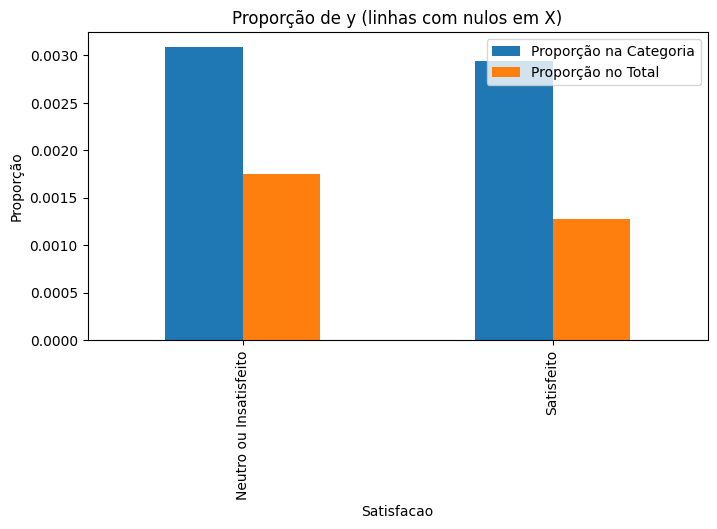


[DISTRIBUIÇÃO DE CLASSES]


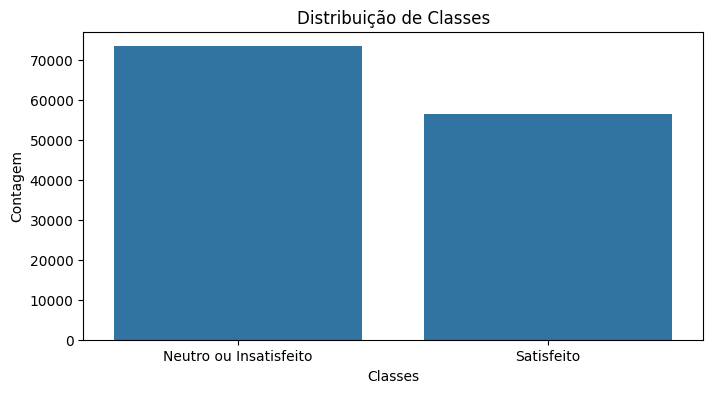

In [ ]:
# Carregar dados para pipeline e vizualiuzação do durante o notebook
df = pl.read_csv('fly_satisfaction.csv')
# Converter para PyArrow Table
arrow_table = df.to_arrow()
# Converter para Pandas DataFrame
df = pd.DataFrame(arrow_table.to_pydict())
df = update_column_names_and_values(df)
# Verificar o DataFrame
print(df.head())
analisando_dados_do_dataset(df)

In [ ]:
import sklearn


def avaliar_modelos_pipeline(X_train, X_test, y_train, y_test, search_spaces, modelo: sklearn.base.BaseEstimator = LogisticRegression, scaled=False, log_transform=False): 
    if scaled:
        pipeline_a_ser_usada = pipeline if log_transform else pipeline_no_log
    else:
        pipeline_a_ser_usada = pipeline_no_scale if log_transform else pipeline_simple
        
    if pipeline_a_ser_usada.get_params().get('classifier') is not None:
        pipeline_a_ser_usada.set_params(classifier=modelo)
    else:
        pipeline_a_ser_usada.steps.append(('classifier', modelo))

    bayes_search = BayesSearchCV(
        estimator=pipeline_a_ser_usada,
        search_spaces=search_spaces,
        scoring='f1',
        n_iter=10,  # Ajuste conforme o tempo disponível
        cv=3,
        n_jobs=-1,
        verbose=2,
        random_state=42,
        refit=True
    )
    print(f"Treinando com a Pipeline: {pipeline_a_ser_usada}")
    # Treina o BayesSearchCV
    bayes_search.fit(X_train, y_train)
    print(f"Melhor pontuação: {bayes_search.best_score_}")
    print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")

    # Pega o melhor pipeline encontrado
    melhor_pipeline = bayes_search.best_estimator_

    # Faz predições com o melhor pipeline
    y_pred_train = cross_val_predict(melhor_pipeline, X_train, y_train, cv=3, n_jobs=-1)

    y_pred_test = melhor_pipeline.predict(X_test)

    return {
        'Modelo': type(melhor_pipeline.named_steps['classifier']).__name__ + (' (Escalado)' if scaled else ''),
        'Melhor Modelo' : bayes_search.best_estimator_,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision Train': precision_score(y_train, y_pred_train),
        'Precision Test': precision_score(y_test, y_pred_test),
        'Recall Train': recall_score(y_train, y_pred_train),
        'Recall Test': recall_score(y_test, y_pred_test),
        'F1 Score Train': f1_score(y_train, y_pred_train),
        'F1 Score Test': f1_score(y_test, y_pred_test),
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'Melhores Hiperparâmetros': bayes_search.best_params_
    }


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Separando os dados em treino e teste
print("DataFrame shape:", df.shape)
print("First few rows of the DataFrame:\n", df.head())

X_pipeline = df.drop('Satisfacao', axis=1)
y_pipeline = df['Satisfacao']
y_pipeline = y_pipeline.map({'Neutro ou Insatisfeito': 0, 'Satisfeito': 1})
# result = acorr_ljungbox(y_pipeline.map({'Neutro ou Insatisfeito':0, 'Satisfeito': 1}), lags=5)
# print(result)  # Se p-valor > 0.05, não há autocorrelação


X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipeline, y_pipeline, test_size=0.3, shuffle=True, stratify=y_pipeline, random_state=42)



DataFrame shape: (129880, 23)
First few rows of the DataFrame:
    Genero      Tipo_Cliente  Idade      Tipo_Viagem     Classe  Distancia_Voo  \
0   Homem  Cliente_Nao_Fiel     48  Viagem_Negocios  Executivo            821   
1  Mulher      Cliente_Fiel     35  Viagem_Negocios  Executivo            821   
2   Homem      Cliente_Fiel     41  Viagem_Negocios  Executivo            853   
3   Homem      Cliente_Fiel     50  Viagem_Negocios  Executivo           1905   
4  Mulher      Cliente_Fiel     49  Viagem_Negocios  Executivo           3470   

   Wifi_Bordo  Horario_Conveniente  Facilidade_Reserva_Online  \
0           3                    3                          3   
1           2                    2                          2   
2           4                    4                          4   
3           2                    2                          2   
4           3                    3                          3   

   Localizacao_Portao  ...  Entretenimento_Bordo  Servico_

In [ ]:
# Avaliação do melhor modelo
dict_modelos_pipeline = {
    'Logistic Regression': {
        'search_spaces': search_spaces_logistic,
        'modelo': LogisticRegression()
    },
    'Random Forest': {
        'search_spaces': search_spaces_random_forest,
        'modelo': RandomForestClassifier()
    },
    'Decision Tree': {
        'search_spaces': search_spaces_decision_tree,
        'modelo': DecisionTreeClassifier()
    },
    'KNN': {
        'search_spaces': search_spaces_knn,
        'modelo': KNeighborsClassifier()
    },
    'SGD Classifier': {
        'search_spaces': search_spaces_sgd,
        'modelo': SGDClassifier()
    },
    'Ridge Classifier': {
        'search_spaces': search_spaces_ridge_classifier,
        'modelo': RidgeClassifier()
    }
}

resultados_pipeline = []
for info in dict_modelos_pipeline.values():
    resultados_pipeline.extend(
        (
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=False,
            ),
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=False,
                log_transform=True
            ),
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=True,
            ),
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=True,
                log_transform=True
            ),
        )
    )



Treinando com a Pipeline: Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_columns at 0x00000181095E5120>)),
                ('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', SimpleImputer(),
                                                  ['Idade', 'Distancia_Voo',
                                                   'Wifi_Bordo',
                                                   'Horario_Conveniente',
                                                   'Localizacao_Portao',
                                                   'Comida_Bebida',
                                                   'Conforto_Assento',
                                                   'Entretenimento_Bordo',
                                                   'Servico_Bordo',
                                                   'Espaco_Pernas',
                                                   '

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Melhor pontuação: 0.8342191914672265
Melhores hiperparâmetros: OrderedDict({'classifier__C': 0.3252108800594495, 'classifier__max_iter': 895})
Treinando com a Pipeline: Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_columns at 0x00000181095E5120>)),
                ('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000018102387920>))]),
                                                  ['Idade', 'Distancia_Voo',
                                                   'Wifi_Bordo',
                                          

In [ ]:
df_resultados = pd.DataFrame(resultados_pipeline)
df_resultados


,Modelo,Melhor Modelo,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Score Train,F1 Score Test,y_pred_train,y_pred_test,Melhores Hiperparâmetros
0,LogisticRegression,(FunctionTransformer(func=<function drop_colum...,0.854305,0.855944,0.824412,0.823230,0.844532,0.851193,0.834350,0.836978,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, ...","{'classifier__C': 0.3252108800594495, 'classif..."
1,LogisticRegression,(FunctionTransformer(func=<function drop_colum...,0.845803,0.848039,0.812122,0.813786,0.839241,0.843159,0.825458,0.828212,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","{'classifier__C': 0.02160217783087772, 'classi..."
2,LogisticRegression (Escalado),(FunctionTransformer(func=<function drop_colum...,0.855603,0.856945,0.826257,0.825890,0.845418,0.849894,0.835728,0.837720,"[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","{'classifier__C': 0.07099668574083867, 'classi..."
3,LogisticRegression (Escalado),(FunctionTransformer(func=<function drop_colum...,0.845418,0.847962,0.810878,0.813361,0.840152,0.843632,0.825256,0.828220,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","{'classifier__C': 0.25041499136197737, 'classi..."
4,RandomForestClassifier,(FunctionTransformer(func=<function drop_colum...,0.945059,0.945257,0.938894,0.937385,0.934354,0.936555,0.936619,0.936970,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...","{'classifier__bootstrap': False, 'classifier__..."
5,RandomForestClassifier,(FunctionTransformer(func=<function drop_colum...,0.946291,0.946232,0.939603,0.937991,0.936582,0.938268,0.938090,0.938129,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...","{'classifier__bootstrap': False, 'classifier__..."
6,RandomForestClassifier (Escalado),(FunctionTransformer(func=<function drop_colum...,0.945620,0.946592,0.937839,0.937939,0.936937,0.939213,0.937388,0.938576,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...","{'classifier__bootstrap': False, 'classifier__..."
7,RandomForestClassifier (Escalado),(FunctionTransformer(func=<function drop_colum...,0.946973,0.948157,0.940995,0.940232,0.936684,0.940454,0.938835,0.940343,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...","{'classifier__bootstrap': False, 'classifier__..."
8,DecisionTreeClassifier,(FunctionTransformer(func=<function drop_colum...,0.944916,0.949748,0.935373,0.941437,0.938025,0.942994,0.936697,0.942215,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, ...","[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","{'classifier__criterion': 'entropy', 'classifi..."
9,DecisionTreeClassifier,(FunctionTransformer(func=<function drop_colum...,0.945048,0.949697,0.934319,0.939615,0.939570,0.944943,0.936937,0.942271,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","{'classifier__criterion': 'entropy', 'classifi..."


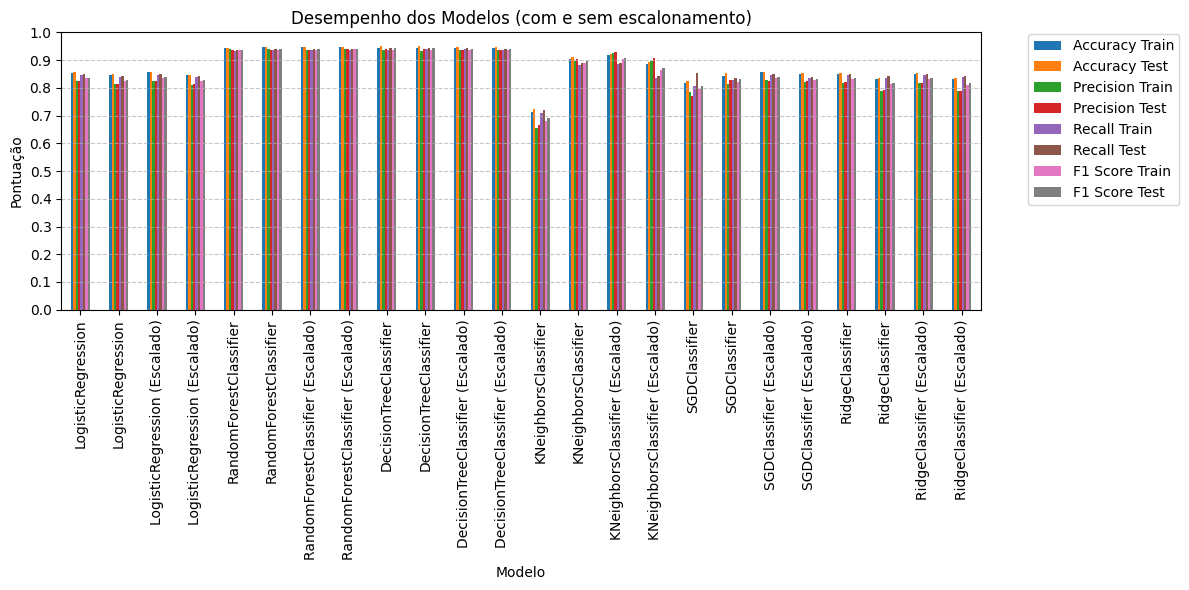

In [ ]:
import matplotlib.ticker as ticker  # Importe para controlar as marcações do eixo

fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_resultados.set_index('Modelo')[[
    'Accuracy Train', 
    'Accuracy Test',
    'Precision Train',
    'Precision Test',
    'Recall Train', 
    'Recall Test',
    'F1 Score Train', 
    'F1 Score Test']]
df_plot.plot(kind='bar', ax=ax)

# Configurar marcações do eixo Y (passos de 0.1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Define intervalos de 0.1
ax.set_ylim(0, 1)  # Garante que o eixo Y vá de 0 a 1 (ajuste se necessário)

# Adicionar grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid horizontal tracejado

# Ajustar legenda fora do gráfico
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.1
)

plt.title('Desempenho dos Modelos (com e sem escalonamento)')
plt.ylabel('Pontuação')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Avaliação do melhor modelo
melhor_modelo = df_resultados.loc[df_resultados['F1 Score Test'].idxmax()]

print(f"Melhor modelo: {melhor_modelo['Modelo']}")
print(f"Melhor F1 Score: {melhor_modelo['F1 Score Test']}")
print(f"Melhores hiperparâmetros: {melhor_modelo['Melhores Hiperparâmetros']}")

modelo_final:DecisionTreeClassifier = melhor_modelo['Melhor Modelo']

# Exportando o melhor modelo
joblib.dump(modelo_final, 'melhor_modelo.pkl')

Melhor modelo: DecisionTreeClassifier
Melhor F1 Score: 0.9422714420358153
Melhores hiperparâmetros: OrderedDict({'classifier__criterion': 'entropy', 'classifier__splitter': 'best'})


['melhor_modelo.pkl']

Acurácia no conjunto de treino: 0.94514716881517
Acurácia no conjunto de teste: 0.9496971563494507
Precisão no conjunto de treino: 0.9347711068000303
Precisão no conjunto de teste: 0.9396146616541353
Recall no conjunto de treino: 0.9392911392405063
Recall no conjunto de teste: 0.9449432892249527
F1 Score no conjunto de treino: 0.9370256721092043
F1 Score no conjunto de teste: 0.9422714420358153


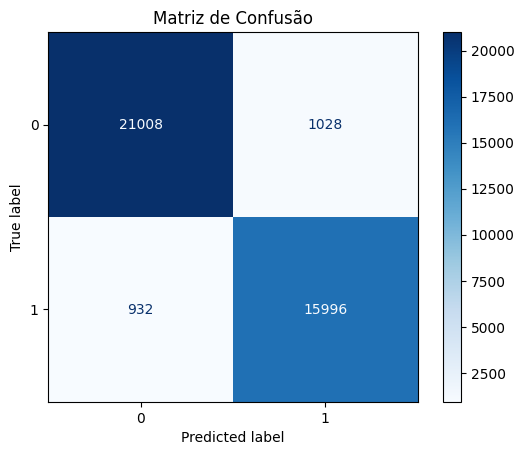

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     22036
           1       0.94      0.94      0.94     16928

    accuracy                           0.95     38964
   macro avg       0.95      0.95      0.95     38964
weighted avg       0.95      0.95      0.95     38964



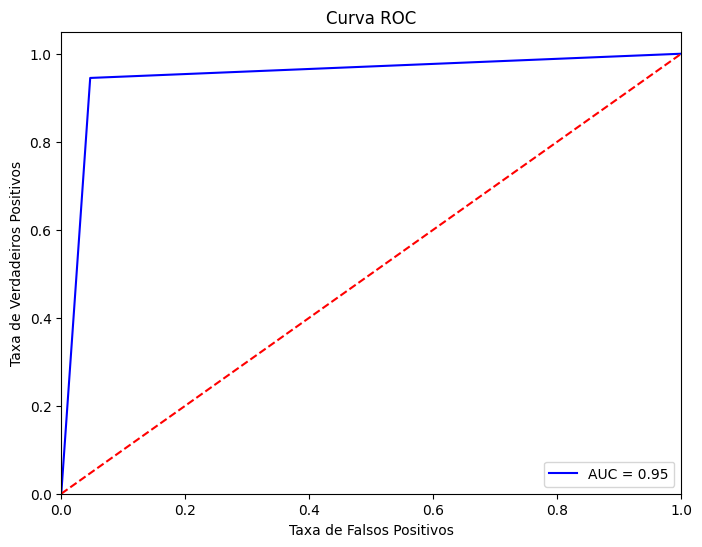

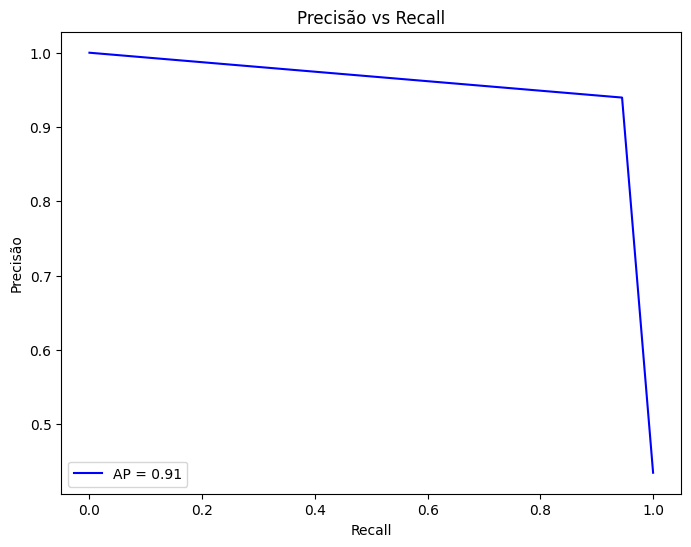

In [ ]:
modelo_final = joblib.load('melhor_modelo.pkl')

# Avaliando o modelo final
y_pred_train = cross_val_predict(modelo_final, X_train_pipe, y_train_pipe, cv=3, n_jobs=-1)
y_pred_test = modelo_final.predict(X_test_pipe)
print("Acurácia no conjunto de treino:", accuracy_score(y_train_pipe, y_pred_train))
print("Acurácia no conjunto de teste:", accuracy_score(y_test_pipe, y_pred_test))
print("Precisão no conjunto de treino:", precision_score(y_train_pipe, y_pred_train))
print("Precisão no conjunto de teste:", precision_score(y_test_pipe, y_pred_test))
print("Recall no conjunto de treino:", recall_score(y_train_pipe, y_pred_train))
print("Recall no conjunto de teste:", recall_score(y_test_pipe, y_pred_test))
print("F1 Score no conjunto de treino:", f1_score(y_train_pipe, y_pred_train))
print("F1 Score no conjunto de teste:", f1_score(y_test_pipe, y_pred_test))
# Plotando a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay


# Matriz de confusão
cm = confusion_matrix(y_test_pipe, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação
print(classification_report(y_test_pipe, y_pred_test))
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_pipe, modelo_final.predict_proba(X_test_pipe)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# precisão vs recall
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_pipe, modelo_final.predict_proba(X_test_pipe)[:, 1])
average_precision = average_precision_score(y_test_pipe, modelo_final.predict_proba(X_test_pipe)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='AP = %0.2f' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Precisão vs Recall')
plt.legend(loc='lower left')
plt.show()